In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization

In [2]:
#loading dataset
data=tf.keras.datasets.mnist
(xtrain,ytrain),(xtest,ytest)= data.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
xtrain,xtest=xtrain/255.0 *2 -1, xtest/255.0 * 2 -1

In [4]:
n,h,w=xtrain.shape
d=h*w
xtrain=xtrain.reshape(-1,d)
xtest=xtest.reshape(-1,d)
print(n,h,w,d)

60000 28 28 784


In [5]:
#Dimensionality of latent space
latent_dim=100

In [6]:
#Generator

def build_generator(latent_dim):
  i=Input(shape=(latent_dim,))
  x=Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=Dense(d,activation='tanh')(x)

  model=Model(i,x)
  return model


In [7]:
# Discriminator

def build_discriminator(image_size):
  i=Input(shape=(image_size,))
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(i)
  x=Dense(256,activation=LeakyReLU(alpha=0.8))(x)
  x=Dense(1,activation='sigmoid')(x)

  model=Model(i,x)
  return model


In [8]:
#compiling both models

#build discriminator and compile with BCE
disc=build_discriminator(d)
disc.compile(loss='binary_crossentropy',optimizer=Adam(0.002,0.5),metrics=['accuracy'])

#initiate generator
gen=build_generator(latent_dim)

#create input for noise sample from latent space
z=Input(shape=(latent_dim,))

#input to generator
img=gen(z)

#freeze discriminator layers
disc.trainable=False

#true output is fake and we label it as real
fake_pred=disc(img)

#final combined model
combined_model=Model(z,fake_pred)

#compiling the model
combined_model.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))

combined_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 784)               1493520   
                                                                 
 model (Functional)          (None, 1)                 533505    
                                                                 
Total params: 2027025 (7.73 MB)
Trainable params: 1489936 (5.68 MB)
Non-trainable params: 537089 (2.05 MB)
_________________________________________________________________


In [9]:
#Training the GAN

#initializing values
batch_size=32
epochs=3000
sample_period=200 #generate and save some data every sample period

#batch labels
ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

#saving the loss values
dloss=[]
gloss=[]

#saving gan images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

#function to generate a grid of random samples from the generator and save in a file
def sample_images(epoch):
  rows,cols=5,5
  noise=np.random.randn(rows * cols, latent_dim)
  img=gen.predict(noise)

  #rescale img
  img=0.5* img + 0.5

  fig,axs=plt.subplots(rows,cols)
  idx=0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(img[idx].reshape(h,w),cmap='gray')
      axs[i,j].axis('off')
      idx+=1
  fig.savefig("gan_image/%d.png"%epoch)
  plt.close()



1/1 [==============================] - 0s 370ms/step
epoch: 1/3000, d_loss:0.82,     d_acc: 0.33, g_loss:0.58
1/1 [==============================] - 0s 21ms/step
epoch: 101/3000, d_loss:0.00,     d_acc: 1.00, g_loss:18.11
1/1 [==============================] - 0s 29ms/step
epoch: 201/3000, d_loss:0.03,     d_acc: 0.98, g_loss:10.93
1/1 [==============================] - 0s 26ms/step
epoch: 301/3000, d_loss:0.89,     d_acc: 0.89, g_loss:25.37
1/1 [==============================] - 0s 21ms/step
epoch: 401/3000, d_loss:0.03,     d_acc: 1.00, g_loss:4.17
1/1 [==============================] - 0s 31ms/step
epoch: 501/3000, d_loss:0.00,     d_acc: 1.00, g_loss:5.84
1/1 [==============================] - 0s 25ms/step
epoch: 601/3000, d_loss:0.08,     d_acc: 1.00, g_loss:2.66
1/1 [==============================] - 0s 25ms/step
epoch: 701/3000, d_loss:0.18,     d_acc: 0.98, g_loss:2.44
1/1 [==============================] - 0s 23ms/step
epoch: 801/3000, d_loss:0.15,     d_acc: 0.98, g_loss:3.42

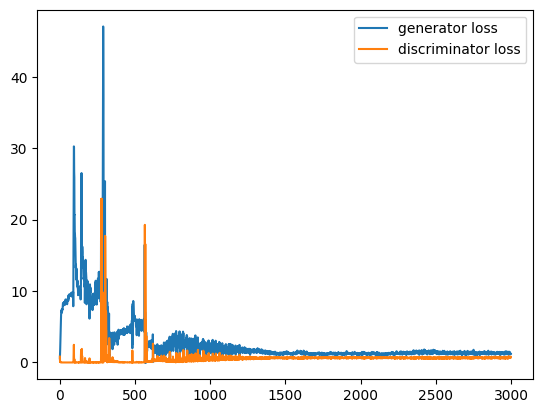

In [10]:
#main training loops
d_losses,g_losses=[],[]
for epoch in range(epochs):

  #train Discriminator

  #select a random batch of images
  idx=np.random.randint(0,xtrain.shape[0], batch_size)
  real_imgs=xtrain[idx]

  #generate fake images
  noise=np.random.randn(batch_size,latent_dim)
  fake_imgs=gen.predict(noise)


  #train the discriminator, loss & accuracy are returned
  d_loss_real,d_acc_real=disc.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake=disc.train_on_batch(fake_imgs,zeros)
  d_loss=0.5*(d_loss_real+d_loss_fake)
  d_acc= 0.5*(d_acc_real+d_acc_fake)


  #train generator
  noise=np.random.randn(batch_size,latent_dim)
  g_loss=combined_model.train_on_batch(noise,ones)

  #save the loss
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch%100==0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss:{d_loss:.2f}, \
    d_acc: {d_acc:.2f}, g_loss:{g_loss:.2f}")

  #if epoch%sample_period==0:
   # sample_images(epoch)



plt.plot(g_losses,label='generator loss')
plt.plot(d_losses, label='discriminator loss')
plt.legend()
